In [11]:
# %pip install seaborn

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import re
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.lines as mlines

file_path = "C:\\Courses\\MSEN655\\MPEA_dataset.csv"
df = pd.read_csv(file_path)
print(df.columns)


print(df[["PROPERTY: Exp. Young modulus (GPa)", 
          "PROPERTY: YS (MPa)", 
          "PROPERTY: Calculated Density (g/cm$^3$)"]].dtypes)

temp = "PROPERTY: Test temperature ($^\circ$C)"
df_filtered = df[df[temp]==25] #Filtering as suggested, but we are not using the filtered dataset for calculations later. 

def property_calc(df): #problem 4 (at room temp) 
    
    
    print(f"Original number of rows: {len(df)}")

    
    df = df[["FORMULA", 
         "PROPERTY: Exp. Young modulus (GPa)", 
         "PROPERTY: YS (MPa)", 
         "PROPERTY: Calculated Density (g/cm$^3$)", "PROPERTY: Elongation (%)"]].dropna()
    df[["PROPERTY: Exp. Young modulus (GPa)", 
        "PROPERTY: YS (MPa)", 
        "PROPERTY: Calculated Density (g/cm$^3$)"]] = df[["PROPERTY: Exp. Young modulus (GPa)", 
                                                         "PROPERTY: YS (MPa)", 
                                                         "PROPERTY: Calculated Density (g/cm$^3$)"]].astype(float)
    
    print(f"Original number of rows: {len(df)}")
    
    YM = df["PROPERTY: Exp. Young modulus (GPa)"]
    YS = df["PROPERTY: YS (MPa)"]
    density = df["PROPERTY: Calculated Density (g/cm$^3$)"]
    specific_stiffness = (YM * 10**9)/(density * 1000) #10e9 * m^2/s^2
    specific_strength = (YS*1000)/(density*1000) #10e3 * m^2/s^2
    
    df["Specific Stiffness"] = specific_stiffness
    df["Specific Strength"] = specific_strength
    
    return df

df = property_calc(df)
print(df[["FORMULA","Specific Stiffness", "Specific Strength", "PROPERTY: Elongation (%)"]].head())

output_file = "Calculated_Properties.xlsx"
df.to_excel(output_file, index=False)


#specific_stiffness, specific_strength = property_calc(df)
#print(specific_strength[:2].values)
print(df.columns)
print(len(df))




Index(['IDENTIFIER: Reference ID', 'FORMULA', 'PROPERTY: Microstructure',
       'PROPERTY: Processing method', 'PROPERTY: BCC/FCC/other',
       'PROPERTY: grain size ($\mu$m)', 'PROPERTY: Exp. Density (g/cm$^3$)',
       'PROPERTY: Calculated Density (g/cm$^3$)', 'PROPERTY: HV',
       'PROPERTY: Type of test', 'PROPERTY: Test temperature ($^\circ$C)',
       'PROPERTY: YS (MPa)', 'PROPERTY: UTS (MPa)', 'PROPERTY: Elongation (%)',
       'PROPERTY: Elongation plastic (%)',
       'PROPERTY: Exp. Young modulus (GPa)',
       'PROPERTY: Calculated Young modulus (GPa)',
       'PROPERTY: O content (wppm)', 'PROPERTY: N content (wppm)',
       'PROPERTY: C content (wppm)', 'REFERENCE: doi', 'REFERENCE: year',
       'REFERENCE: title'],
      dtype='object')
PROPERTY: Exp. Young modulus (GPa)         float64
PROPERTY: YS (MPa)                         float64
PROPERTY: Calculated Density (g/cm$^3$)    float64
dtype: object
Original number of rows: 1545
Original number of rows: 58
        

In [12]:
#cost estimation problem 5
#atomic_wt = {"Al":26.98,"Co":58.93,"Fe":55.85,"Ni":58.69,"Si":28.09,"Cu":63.55,"Mn":54.94,"Cr":52.00}
#element_prices = {"Al":2.59,"Co":21.56,"Fe":0.10,"Ni":15.23,"Si":3.17,"Cu":9.38,"Mn":1.82,"Cr":9.40}
#USD per kg
append_path = "C:\\Courses\\MSEN655\\appendix.csv"
df_appendix = pd.read_csv(append_path)
print(df_appendix.columns)

atomic_wt = dict(zip(df_appendix["Element"],df_appendix["Atomic Weight (g/mol)"]))
element_prices = dict(zip(df_appendix["Element"],df_appendix["Price (USD/kg)"]))


def parse_mat(c):
    pattern = r"([A-Za-z]+)([\d\.]*)"
    matches = re.findall(pattern,c) # return a list with tuple
    elements = {}
    for element,ratio in matches:
        if element in atomic_wt:
            elements[element] = float(ratio) if ratio else 1.0
        
    return elements # dictionary

def wt_percent(c): # in % ！！
    
    tot_mass = sum(c[element] * atomic_wt[element] for element in c)
    wt_percent = {}
    for element,mol_frac in c.items():
        if element in atomic_wt:
            wt_percent[element] = mol_frac * atomic_wt[element]/tot_mass * 100

    return wt_percent# dictionary

def cost_calc(c):
    price = 0
    for element, wt_percent in c.items():
        price += wt_percent/100 * element_prices[element]
    return price
    
    
df["parsed"] = df["FORMULA"].apply(parse_mat)
df["wt_percent"] = df["parsed"].apply(wt_percent)
df["price(USD/KG)"] = df["wt_percent"].apply(cost_calc)

df["price(USD/KG)"][:10] #test

    

Index(['Element', 'Atomic Weight (g/mol)', 'Price (USD/kg)'], dtype='object')


112      11.476734
113      11.171618
114      11.736444
269    1376.932173
270    1364.672985
271    1349.653163
272    1334.960978
273    1395.740379
310    1342.507956
311    1293.269535
Name: price(USD/KG), dtype: float64

In [13]:
#Materials Selection

#Using same relations in problem for calculation of Specific Strentgh and Specific Stiffness of 316L
#Specific Stiffness= 195×10^9Pa/8000kgm^3 = 24.375 MN.m.kg
#Specific Strength = 270x10^6Pa/8000kgm^3 = 33.75 KN.m.kg

#Filtering materials using 316L as baseline
ss_316_stiffness = 24375000 # Recheck values based on density units
ss_316_strength = 33750

print(df.columns)

if "price(USD/KG)" not in df.columns:
    df["parsed"] = df["FORMULA"].apply(parse_mat)
    df["wt_percent"] = df["parsed"].apply(wt_percent)
    df["price(USD/KG)"] = df["wt_percent"].apply(cost_calc) 
    
print(df[["FORMULA", "Specific Stiffness", "Specific Strength", "price(USD/KG)"]].head())
filtered_1 = df[df["Specific Stiffness"] >= ss_316_stiffness]
filtered_2 = df[(df["Specific Stiffness"] >= ss_316_stiffness) & (df["Specific Strength"] >= ss_316_strength)]
filtered_3 = filtered_2.sort_values(by="price(USD/KG)")
filtered_4 = filtered_3[df["PROPERTY: Elongation (%)"] > 10]


# Multi-objective selection
scaler = MinMaxScaler()
df_scaled = df.copy()
df_scaled["FORMULA"] = df["FORMULA"]

# Scaling
scaling_columns = ["Specific Stiffness", "Specific Strength", "price(USD/KG)", "PROPERTY: Elongation (%)"]
df_scaled[scaling_columns] = scaler.fit_transform(df[scaling_columns])

#To later reverse the scaling
scaler_stiffness = scaler.fit(df[["Specific Stiffness"]])
scaler_strength = scaler.fit(df[["Specific Strength"]])
scaler_cost = scaler.fit(df[["price(USD/KG)"]])
scaler_elongation = scaler.fit(df[["PROPERTY: Elongation (%)"]])

# Assigning weights (maximise specific strength, stiffness, elongation and minimise cost)
weights = np.array([0.3, 0.3, -0.2, 0.2])  # Adjusting weights for all criteria
df_scaled["Weighted Score"] = df_scaled[scaling_columns].dot(weights)

# Selecting top materials based on weighted scores
top_materials = df_scaled.nlargest(5, "Weighted Score")

# Reversing the scaling for the selected top materials
top_materials["Specific Stiffness"] = scaler_stiffness.inverse_transform(top_materials[["Specific Stiffness"]])
top_materials["Specific Strength"] = scaler_strength.inverse_transform(top_materials[["Specific Strength"]])
top_materials["price(USD/KG)"] = scaler_cost.inverse_transform(top_materials[["price(USD/KG)"]])
top_materials["PROPERTY: Elongation (%)"] = scaler_elongation.inverse_transform(top_materials[["PROPERTY: Elongation (%)"]])

top_materials = top_materials.merge(df[["FORMULA"]], on="FORMULA", how="left")


print("Top materials based on multi-objective selection:")
print(top_materials[["FORMULA", "Specific Stiffness", "Specific Strength", "price(USD/KG)", "PROPERTY: Elongation (%)", "Weighted Score"]])

Index(['FORMULA', 'PROPERTY: Exp. Young modulus (GPa)', 'PROPERTY: YS (MPa)',
       'PROPERTY: Calculated Density (g/cm$^3$)', 'PROPERTY: Elongation (%)',
       'Specific Stiffness', 'Specific Strength', 'parsed', 'wt_percent',
       'price(USD/KG)'],
      dtype='object')
                                         FORMULA  Specific Stiffness  \
112                      Al1 Co1 Cr1 Fe1 Ni1 Ti1        1.451613e+07   
113                    Al1 Co1 Cr1 Fe1 Ni1 Ti0.5        2.781250e+07   
114  Al0.667 Co0.667 Cr0.667 Fe0.667 Ni0.667 Ti1        2.622951e+07   
269                    Al0.3 Hf1 Nb1 Ta1 Ti1 Zr1        6.631579e+06   
270                    Al0.5 Hf1 Nb1 Ta1 Ti1 Zr1        1.043011e+07   

     Specific Strength  price(USD/KG)  
112         300.000000      11.476734  
113         353.125000      11.171618  
114         363.934426      11.736444  
269         125.052632    1376.932173  
270         140.000000    1364.672985  
Top materials based on multi-objective selection:


C:\Users\Himanshu Balhara\AppData\Local\Temp\ipykernel_28616\1214852307.py:22: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  filtered_4 = filtered_3[df["PROPERTY: Elongation (%)"] > 10]


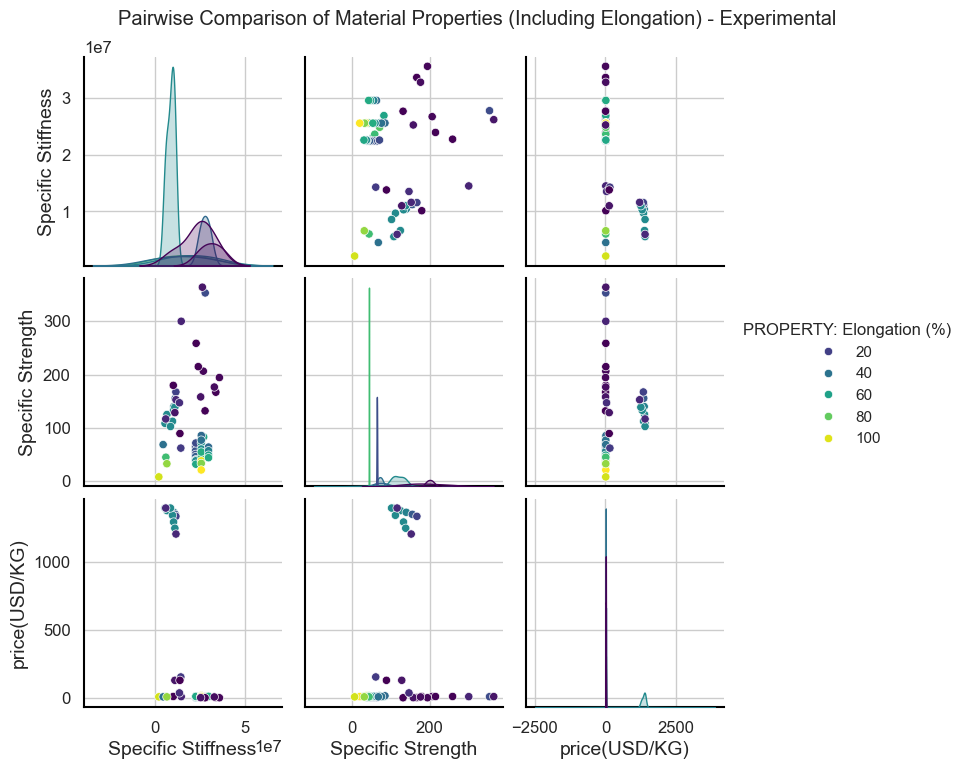

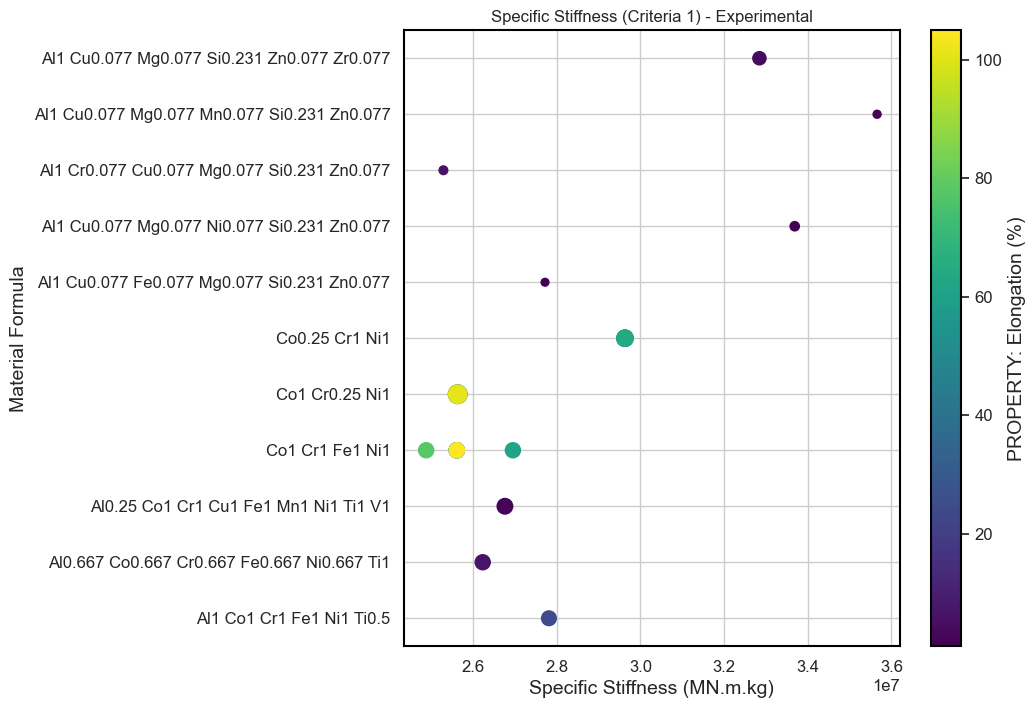

C:\Users\Himanshu Balhara\AppData\Local\Temp\ipykernel_28616\2651738198.py:40: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=filtered_2, x="Specific Stiffness", y="Specific Strength", hue="PROPERTY: Elongation (%)", size="price(USD/KG)", sizes=(50, 300), palette="coolwarm", legend="full")
C:\Users\Himanshu Balhara\AppData\Local\Temp\ipykernel_28616\2651738198.py:44: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Material", loc="upper left", bbox_to_anchor=(1, 1))  # Adjusted legend to show material names


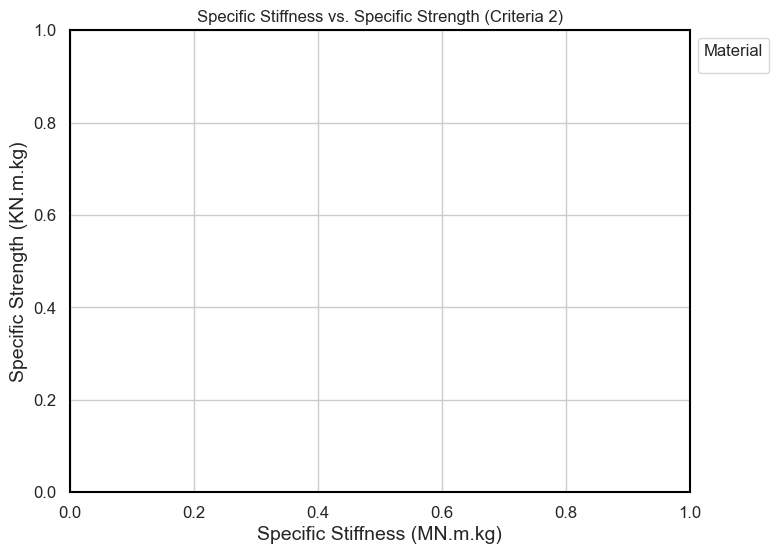

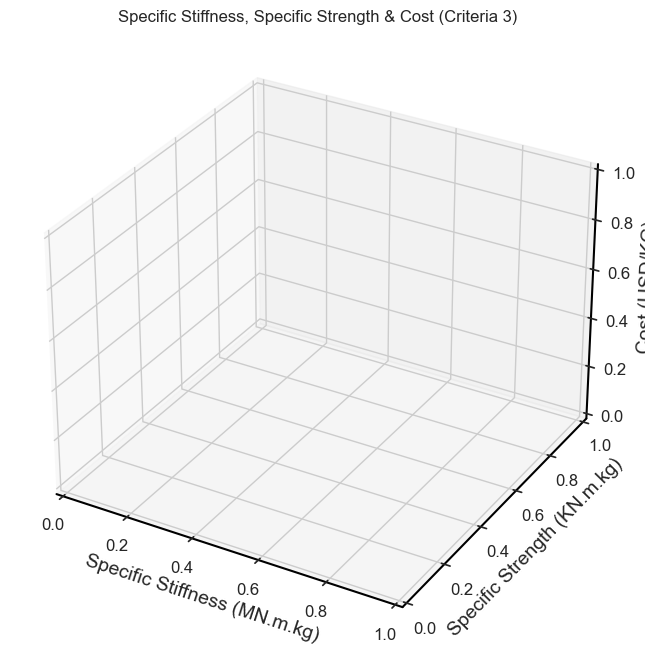

C:\Users\Himanshu Balhara\AppData\Local\Temp\ipykernel_28616\2651738198.py:60: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  sns.scatterplot(data=filtered_4, x="Specific Stiffness", y="Specific Strength", hue="PROPERTY: Elongation (%)", size="price(USD/KG)", sizes=(50, 300), palette="viridis", legend="full")
C:\Users\Himanshu Balhara\AppData\Local\Temp\ipykernel_28616\2651738198.py:64: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(title="Material", loc="upper left", bbox_to_anchor=(1, 1))  # Adjusted legend to show material names


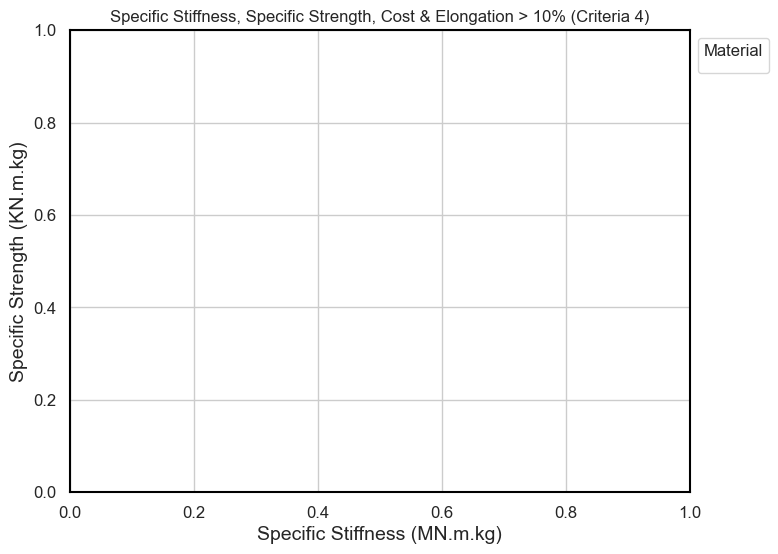

In [19]:
# Set plot style
sns.set(style="whitegrid", rc={"axes.edgecolor": "black", "axes.linewidth": 1.5, "axes.labelsize": 14, "xtick.labelsize": 12, "ytick.labelsize": 12})

# Pairwise Plot
pairplot = sns.pairplot(df, vars=["Specific Stiffness", "Specific Strength", "price(USD/KG)"], hue="PROPERTY: Elongation (%)", palette="viridis")
pairplot.fig.suptitle("Pairwise Comparison of Material Properties (Including Elongation) - Experimental", y=1.02)

# Customize the axes
for ax in pairplot.axes.flatten():
    if ax is not None:
        # Set the edge color and line width for the plot boundaries
        for spine in ax.spines.values():
            spine.set_edgecolor('black')
            spine.set_linewidth(1.5)
        # Increase the size of the axis labels
        ax.set_xlabel(ax.get_xlabel(), fontsize=14)
        ax.set_ylabel(ax.get_ylabel(), fontsize=14)
        # Increase the size of the tick labels
        ax.tick_params(axis='both', which='major', labelsize=12)

plt.show()

# 1. Specific Stiffness
plt.figure(figsize=(8, 8))
scatter = plt.scatter(x=filtered_1["Specific Stiffness"], y=filtered_1["FORMULA"], c=filtered_1["PROPERTY: Elongation (%)"], s=filtered_1["price(USD/KG)"] * 10, cmap="viridis")  # Increased size by multiplying by 10
plt.title("Specific Stiffness (Criteria 1) - Experimental")
plt.xlabel("Specific Stiffness (MN.m.kg)")
plt.ylabel("Material Formula")

# Create a colorbar
norm = plt.Normalize(filtered_1["PROPERTY: Elongation (%)"].min(), filtered_1["PROPERTY: Elongation (%)"].max())
sm = plt.cm.ScalarMappable(cmap="viridis", norm=norm)
sm.set_array([])
plt.colorbar(sm, ax=plt.gca(), label="PROPERTY: Elongation (%)")

plt.show()

# 2. Specific Stiffness vs. Specific Strength
plt.figure(figsize=(8, 6))
sns.scatterplot(data=filtered_2, x="Specific Stiffness", y="Specific Strength", hue="PROPERTY: Elongation (%)", size="price(USD/KG)", sizes=(50, 300), palette="coolwarm", legend="full")
plt.title("Specific Stiffness vs. Specific Strength (Criteria 2)")
plt.xlabel("Specific Stiffness (MN.m.kg)")
plt.ylabel("Specific Strength (KN.m.kg)")
plt.legend(title="Material", loc="upper left", bbox_to_anchor=(1, 1))  # Adjusted legend to show material names
plt.show()

# 3. Specific Stiffness, Specific Strength, and Cost
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(filtered_3["Specific Stiffness"], filtered_3["Specific Strength"], filtered_3["price(USD/KG)"], c=filtered_3["PROPERTY: Elongation (%)"], cmap="viridis", s=100)
ax.set_xlabel("Specific Stiffness (MN.m.kg)")
ax.set_ylabel("Specific Strength (KN.m.kg)")
ax.set_zlabel("Cost (USD/KG)")
plt.title("Specific Stiffness, Specific Strength & Cost (Criteria 3)")
plt.show()

# 4. Specific Stiffness, Specific Strength, Cost & Elongation > 10%
filtered_4 = filtered_4[filtered_4["PROPERTY: Elongation (%)"] > 10]
plt.figure(figsize=(8, 6))
sns.scatterplot(data=filtered_4, x="Specific Stiffness", y="Specific Strength", hue="PROPERTY: Elongation (%)", size="price(USD/KG)", sizes=(50, 300), palette="viridis", legend="full")
plt.title("Specific Stiffness, Specific Strength, Cost & Elongation > 10% (Criteria 4)")
plt.xlabel("Specific Stiffness (MN.m.kg)")
plt.ylabel("Specific Strength (KN.m.kg)")
plt.legend(title="Material", loc="upper left", bbox_to_anchor=(1, 1))  # Adjusted legend to show material names
plt.show()

# #Pairwise Plot
# sns.pairplot(df, vars=["Specific Stiffness", "Specific Strength", "price(USD/KG)"], hue="PROPERTY: Elongation (%)", palette="RdYlGn")
# plt.title("Pairwise Comparison of Material Properties (Including Elongation)")
# plt.show()
